In [1]:
from autorank import autorank, plot_stats, create_report
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from skcriteria.pipeline import mkpipe
from skcriteria.preprocessing.invert_objectives import (
    InvertMinimize,
    NegateMinimize,
)
from skcriteria.cmp import mkrank_cmp
from skcriteria.preprocessing.filters import FilterNonDominated
from skcriteria.preprocessing.scalers import SumScaler, VectorScaler
from skcriteria.agg.simple import WeightedProductModel, WeightedSumModel
from skcriteria.agg.similarity import TOPSIS


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [ ]:
import pandas as pd

from code.utils import rank_and_sort

model = 'spectral'
dataset = 'sick'
df = pd.read_csv(f'./output/results_{model}_{dataset}.csv')
result = rank_and_sort(df)
result


,Unnamed: 0,k,affinity,assign_labels,n_neighbors,eigen_solver,ARI,Purity,F-Measure,Davies-Bouldin Index,Silhouette Coefficient,Davies-Bouldin Index_Rank,Silhouette Coefficient_Rank,Mean_Rank
0,0,2,rbf,kmeans,NaN,arpack,0.006617,0.961008,0.950822,0.939946,0.352821,1.5,3.5,2.5
1,1,2,rbf,kmeans,NaN,lobpcg,0.006617,0.961008,0.950822,0.939946,0.352821,1.5,3.5,2.5
2,43,7,rbf,discretize,NaN,lobpcg,0.003059,0.961008,0.529880,1.196921,0.361073,6.0,1.0,3.5
3,2,2,rbf,discretize,NaN,arpack,0.004291,0.961008,0.949329,0.972667,0.352323,3.5,5.5,4.5
4,3,2,rbf,discretize,NaN,lobpcg,0.004291,0.961008,0.949329,0.972667,0.352323,3.5,5.5,4.5
5,42,7,rbf,discretize,NaN,arpack,0.003132,0.961008,0.529602,1.207853,0.360995,7.0,2.0,4.5
6,36,6,nearest_neighbors,kmeans,200.0,arpack,0.003573,0.961008,0.573553,1.145728,0.350394,5.0,7.0,6.0


In [9]:
import os

df = pd.DataFrame()

path = './output/'

for file in os.listdir(path):
    df_file = pd.read_csv(path+file)
    df_max = df_file[df_file['Silhouette Coefficient'] == df_file['Silhouette Coefficient'].max()].head(1)
    df_max['Method'] = file.split('_')[1]
    df_max['Dataset'] = file.split('_')[2].split('.')[0]
    df = pd.concat((df, df_max))

df = df[['Method', 'Dataset' ,'Davies-Bouldin Index', 'Silhouette Coefficient', 'F-Measure', 'ARI']]

IndexError: list index out of range

In [76]:
df = df.fillna(0.001)

In [77]:
df['ARI'] = abs(df['ARI'])

In [78]:
import skcriteria as skc
df_dataset = df[df['Dataset'] == 'vowel']
df_dataset = df_dataset.set_index('Method')
df_dataset = df_dataset.drop(columns=['Dataset'])
objectives = [min, max, max, max]
objectives
dm = skc.mkdm(df_dataset.values,
              objectives,
              alternatives=df_dataset.index,
              criteria=df_dataset.columns)
dm

,Davies-Bouldin Index[▼ 1.0],Silhouette Coefficient[▲ 1.0],F-Measure[▲ 1.0],ARI[▲ 1.0]
fuzzyclustering,1.252484,0.422499,0.125000,0.001000
gmeans,1.769101,0.271164,0.135593,0.006304
kmeans,1.225643,0.336704,0.155340,0.003497
optics,1.300938,0.399283,0.140826,0.000299
spectral,1.743033,0.270584,0.135593,0.006304


In [79]:

ws_pipe = mkpipe(
    InvertMinimize(),
    FilterNonDominated(),
    SumScaler(target="weights"),
    VectorScaler(target="matrix"),
    WeightedSumModel(),
)

wp_pipe = mkpipe(
    InvertMinimize(),
    FilterNonDominated(),
    SumScaler(target="weights"),
    VectorScaler(target="matrix"),
    WeightedProductModel(),
)

tp_pipe = mkpipe(
    NegateMinimize(),
    FilterNonDominated(),
    SumScaler(target="weights"),
    VectorScaler(target="matrix"),
    TOPSIS(),
)

wsum_result = ws_pipe.evaluate(dm)
wprod_result = wp_pipe.evaluate(dm)
tp_result = tp_pipe.evaluate(dm)

display(wsum_result, wprod_result, tp_result)

Alternatives,fuzzyclustering,gmeans,kmeans,optics,spectral
Rank,4,3,1,5,2


Alternatives,fuzzyclustering,gmeans,kmeans,optics,spectral
Rank,4,3,1,5,2


Alternatives,fuzzyclustering,gmeans,kmeans,optics,spectral
Rank,4,2,3,5,1


In [80]:
rcmp = mkrank_cmp(tp_result, wsum_result, wprod_result)
rcmp.to_dataframe()


Method,TOPSIS,WeightedSumModel,WeightedProductModel
Alternatives,,,
fuzzyclustering,4,4,4
gmeans,2,3,3
kmeans,3,1,1
optics,5,5,5
spectral,1,2,2


<Axes: xlabel='Method', ylabel='Ranks (lower is better)'>

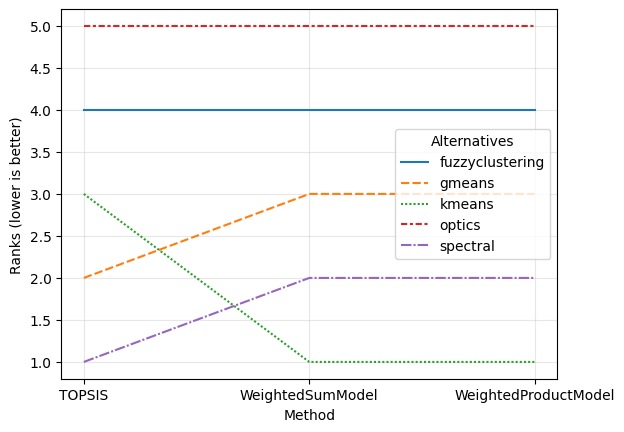

In [81]:
rcmp.plot.flow()

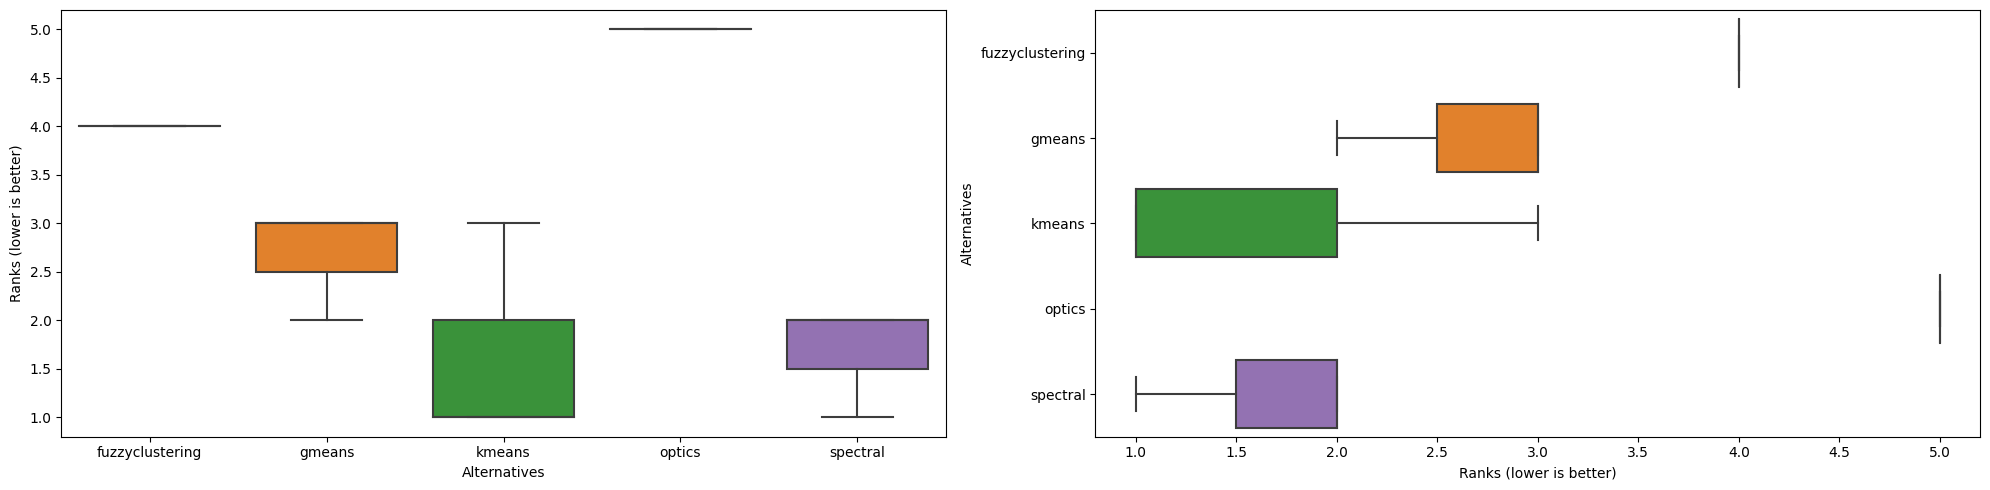

In [82]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

rcmp.plot.box(ax=axs[0])
rcmp.plot.box(ax=axs[1], orient="h")

fig.tight_layout()